In [1]:
from scipy.io import loadmat, savemat
from scipy.linalg import orth
import numpy as np
import faiss
from scipy.spatial.distance import cdist
import pandas as pd

from tqdm import tqdm
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import gc
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

from randn2 import randn2 
import peer_functions as peer

import math
from tqdm import tqdm
os.environ['OPENBLAS_NUM_THREADS'] = '1'

from datasets import ExperimentRunner


c:\Users\21361535\AppData\Local\anaconda3\envs\lava3\lib\site-packages\lava\utils\profiler.py:16: UserWarning: Loihi2HWProfiler could not be imported. Currently no profiler is available.
  warnings.warn("Loihi2HWProfiler could not be imported. "


In [2]:
from dot_product import CPUDotProduct, CPUDotProductPositive, LoihiDotProductSimulationPositiveDBScale


## SNN 2 Layer

In [3]:
constant = 1/math.sqrt(2)

# Dummy Data
D1    = loadmat("../datasets/descriptors/GardensPointWalking/day_left/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
D2    = loadmat("../datasets/descriptors/GardensPointWalking/night_right/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']

g_truth = loadmat("../datasets/ground_truth/GardensPointWalking/day_left--night_right/gt.mat")

# dot = LoihiDotProductSimulationPositiveDBScale(D1, D2, constant, timesteps=16, dbScale=6*3)
dot = CPUDotProduct(D1, D2)


In [4]:
DD = dot.run(D2, D1)#, customTimesteps=16)

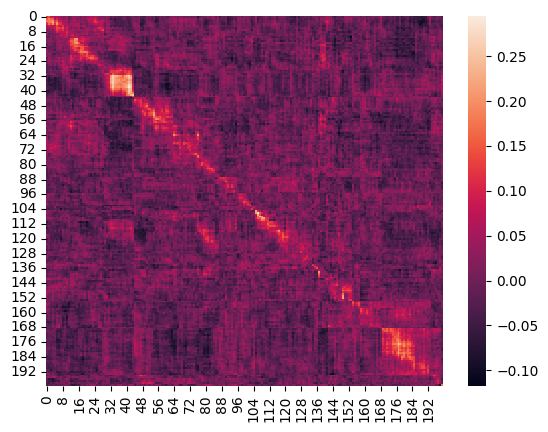

In [5]:
import seaborn as sns

ax = sns.heatmap(DD)
plt.show()

In [6]:

def calculate_evaluation_metrics(similarity_matrix, ground_truth):
    """
    Calculate evaluation metrics for place recognition results
    
    Args:
        similarity_matrix: Matrix of similarity scores between queries and database
        ground_truth: Ground truth data containing GThard and GTsoft
        
    Returns:
        dict: Dictionary containing recalls, precision, recall curves and AUC
    """
    # Get candidate selections
    ids_pos = peer.directCandSel(similarity_matrix)
    
    # Calculate recall values
    recalls = peer.getRecallAtKVector(ids_pos, ground_truth["GT"])
    
    # Calculate precision-recall curves and AUC
    [R, P] = peer.createPR(-similarity_matrix, 
                          ground_truth['GT']["GThard"][0][0], 
                          ground_truth['GT']["GTsoft"][0][0])
    auc = np.trapz(P, R)
    
    return {
        'recalls': recalls,
        'precision': P,
        'recall': R,
        'auc': auc
    }


metrics = calculate_evaluation_metrics(-DD, g_truth)
print(f"AUC: {metrics['auc']}")


AUC: 0.49053475950273334


In [7]:
exp = ExperimentRunner(dot)

In [9]:
# results = exp.run_all_experiments(customTimesteps=10, sparsify=True)
results = exp.run_all_experiments(sparsify=True)

========== Evaluating GardensPointWalking ============
Similarity computation time: 0.05 ms
GardensPointWalking - day_left - night_right : 0.44023328088182867 - 0.05 ms - db_size : 200
Similarity computation time: 0.10 ms
GardensPointWalking - day_right - night_right : 0.7357298037841964 - 0.10 ms - db_size : 200
Similarity computation time: 0.06 ms
GardensPointWalking - day_right - day_left : 0.8069183065451175 - 0.06 ms - db_size : 200
========== Evaluating SFUMountain ============
Similarity computation time: 0.09 ms
SFUMountain - dry - dusk : 0.6826172964035346 - 0.09 ms - db_size : 385
Similarity computation time: 0.10 ms
SFUMountain - dry - jan : 0.5378948024735648 - 0.10 ms - db_size : 385
Similarity computation time: 0.10 ms
SFUMountain - dry - wet : 0.6122790278722406 - 0.10 ms - db_size : 385
========== Evaluating Nordland1000 ============
Similarity computation time: 0.11 ms
Nordland1000 - spring - winter : 0.7090321179697826 - 0.11 ms - db_size : 1000
Similarity computation

AssertionError: S_in and GThard must have the same shape

In [10]:
results

{'GardensPointWalking': [{'db': 'day_left',
   'query': 'night_right',
   'auc': {'precision': [1,
     1.0,
     1.0,
     1.0,
     1.0,
     1.0,
     1.0,
     0.75,
     0.75,
     0.75,
     0.75,
     0.8,
     0.8,
     0.8333333333333334,
     0.8571428571428571,
     0.875,
     0.8181818181818182,
     0.8181818181818182,
     0.8181818181818182,
     0.8333333333333334,
     0.8461538461538461,
     0.8125,
     0.8125,
     0.8333333333333334,
     0.8571428571428571,
     0.8181818181818182,
     0.84,
     0.84375,
     0.8285714285714286,
     0.8421052631578947,
     0.8604651162790697,
     0.82,
     0.7719298245614035,
     0.7391304347826086,
     0.7088607594936709,
     0.6704545454545454,
     0.6239316239316239,
     0.572463768115942,
     0.5151515151515151,
     0.4587628865979381,
     0.38461538461538464,
     0.32781456953642385,
     0.3002832861189802,
     0.255125284738041,
     0.21755027422303475,
     0.17725258493353027,
     0.14564220183486237,


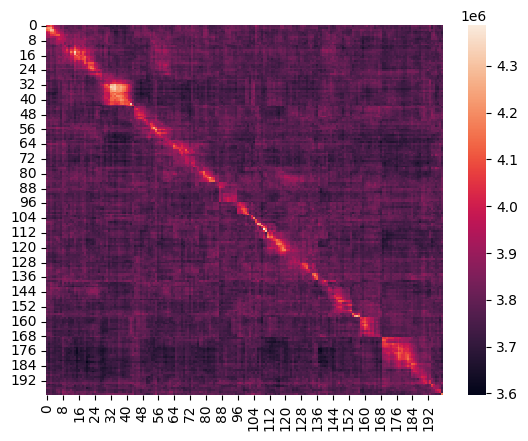

In [7]:
import seaborn as sns

ax = sns.heatmap(results['GardensPointWalking'][0]['DD'])
plt.show()


## CPU Standard Dot Product

In [14]:
dot_cpu = CPUDotProduct(D1, D2)

In [15]:
exp_cpu = ExperimentRunner(dot_cpu)

In [16]:
results_cpu = exp_cpu.run_all_experiments()


========== Evaluating GardensPointWalking ============
Similarity computation time: 0.39 ms
GardensPointWalking - day_left - night_right : 0.4702147082864312 - 0.39 ms - db_size : 200
Similarity computation time: 0.41 ms
GardensPointWalking - day_right - night_right : 0.7582461748985041 - 0.41 ms - db_size : 200
Similarity computation time: 0.40 ms
GardensPointWalking - day_right - day_left : 0.8237447049227817 - 0.40 ms - db_size : 200
========== Evaluating CMU ============
Similarity computation time: 2.51 ms
CMU - 20110421 - 20100901 : 0.7119823998759446 - 2.51 ms - db_size : 1155
Similarity computation time: 2.44 ms
CMU - 20110421 - 20100915 : 0.7099356461286594 - 2.44 ms - db_size : 1155
Similarity computation time: 2.64 ms
CMU - 20110421 - 20101221 : 0.6306503833259404 - 2.64 ms - db_size : 1155
Similarity computation time: 2.57 ms
CMU - 20110421 - 20110202 : 0.6820773907902565 - 2.57 ms - db_size : 1155
========== Evaluating SFUMountain ============
Similarity computation time: 

## For Loops

In [8]:
from dot_product import CPUDotProductPositiveForLoop

dot_cpu_for = CPUDotProductPositiveForLoop(D1, D2, constant)
exp_cpu_for = ExperimentRunner(dot_cpu_for)

In [9]:
results_cpu_for = exp_cpu_for.run_all_experiments()

========== Evaluating GardensPointWalking ============
Similarity computation time: 4.69 ms
GardensPointWalking - day_left - night_right : 0.3483199833406223 - 4.69 ms - db_size : 200
Similarity computation time: 4.49 ms
GardensPointWalking - day_right - night_right : 0.6828675979541299 - 4.49 ms - db_size : 200
Similarity computation time: 4.50 ms
GardensPointWalking - day_right - day_left : 0.766212373740079 - 4.50 ms - db_size : 200
========== Evaluating CMU ============
Similarity computation time: 58.17 ms
CMU - 20110421 - 20100901 : 0.5329386692450612 - 58.17 ms - db_size : 1155
Similarity computation time: 56.35 ms
CMU - 20110421 - 20100915 : 0.5564904835088946 - 56.35 ms - db_size : 1155
Similarity computation time: 50.17 ms
CMU - 20110421 - 20101221 : 0.5817727341148954 - 50.17 ms - db_size : 1155
Similarity computation time: 45.51 ms
CMU - 20110421 - 20110202 : 0.479021682146223 - 45.51 ms - db_size : 1155
========== Evaluating SFUMountain ============
Similarity computation 

In [6]:
DELF_HDC_AUC_Orig = {
    "GardensPointWalking": {
        "day_right vs day_left": 0.82,
        "day_right vs night_right": 0.79,
        "day_left vs night_right": 0.46
    },
    "OxfordRobotCar": {
        "2014-12-09-13-21-02 vs 2015-05-19-14-06-38": 0.90,
        "2014-12-09-13-21-02 vs 2015-08-28-09-50-22": 0.70,
        "2014-12-09-13-21-02 vs 2014-11-25-09-18-32": 0.80,
        "2014-12-09-13-21-02 vs 2014-12-16-18-44-24": 0.78,
        "2015-05-19-14-06-38 vs 2015-02-03-08-45-10": 0.75,
        "2015-08-28-09-50-22 vs 2014-11-25-09-18-32": 0.69
    },
    "SFUMountain": {
        "dry vs dusk": 0.79,
        "dry vs jan": 0.55,
        "dry vs wet": 0.73
    },
    "CMU": {
        "20110421 vs 20100901": 0.74,
        "20110421 vs 20100915": 0.73,
        "20110421 vs 20101221": 0.63,
        "20110421 vs 20110202": 0.71
    },
    "Nordland1k": {
        "spring vs winter": 0.74,
        "spring vs summer": 0.72,
        "summer vs winter": 0.46,
        "summer vs fall": 0.89
    },
    "StLucia": {
        "100909_0845 vs 180809_1545": 0.44,
        "100909_1000 vs 190809_1410": 0.63,
        "100909_1210 vs 210809_1210": 0.69
    }
}


In [7]:
# Updated data for Loihi SNN and CPU:Numpy
loihi_data = {
    "GardensPointWalking": {
        "day_left vs night_right": 0.4264954039922729,
        "day_right vs night_right": 0.7755908048631537,
        "day_right vs day_left": 0.8036863523309037,
    },
    "CMU": {
        "20110421 vs 20100901": 0.7535629080075785,
        "20110421 vs 20100915": 0.7310901213993263,
        "20110421 vs 20101221": 0.6343342394233842,
        "20110421 vs 20110202": 0.5140964549730641,
    },
    "SFUMountain": {
        "dry vs dusk": 0.7958713069198795,
        "dry vs jan": 0.5564577717582593,
        "dry vs wet": 0.5512968533207703,
    },
}

cpu_numpy_data = {
    "GardensPointWalking": {
        "day_left vs night_right": 0.4660135714632877,
        "day_right vs night_right": 0.7594964895309881,
        "day_right vs day_left": 0.8245687650989478,
    },
    "CMU": {
        "20110421 vs 20100901": 0.7114807137837953,
        "20110421 vs 20100915": 0.7097341186912527,
        "20110421 vs 20101221": 0.6305503198813669,
        "20110421 vs 20110202": 0.6825789106649272,
    },
    "SFUMountain": {
        "dry vs dusk": 0.7094702633209764,
        "dry vs jan": 0.5816537507527371,
        "dry vs wet": 0.6587555217913912,
    },
}


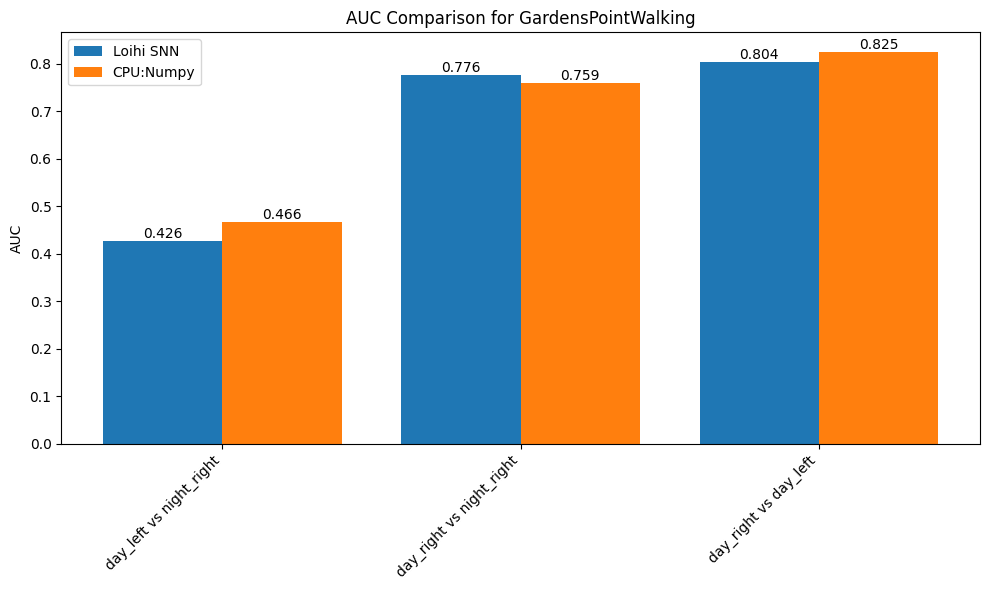

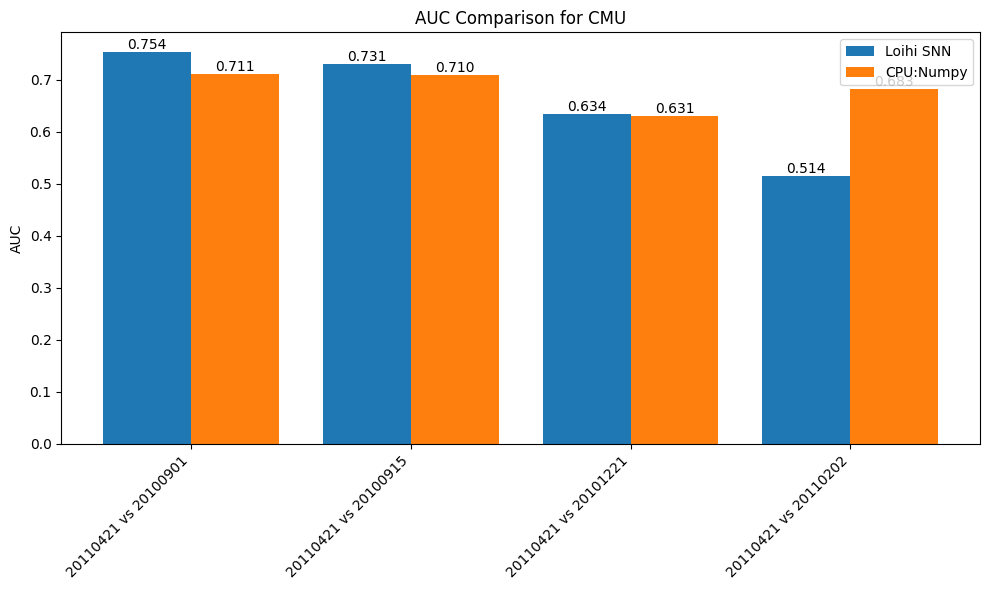

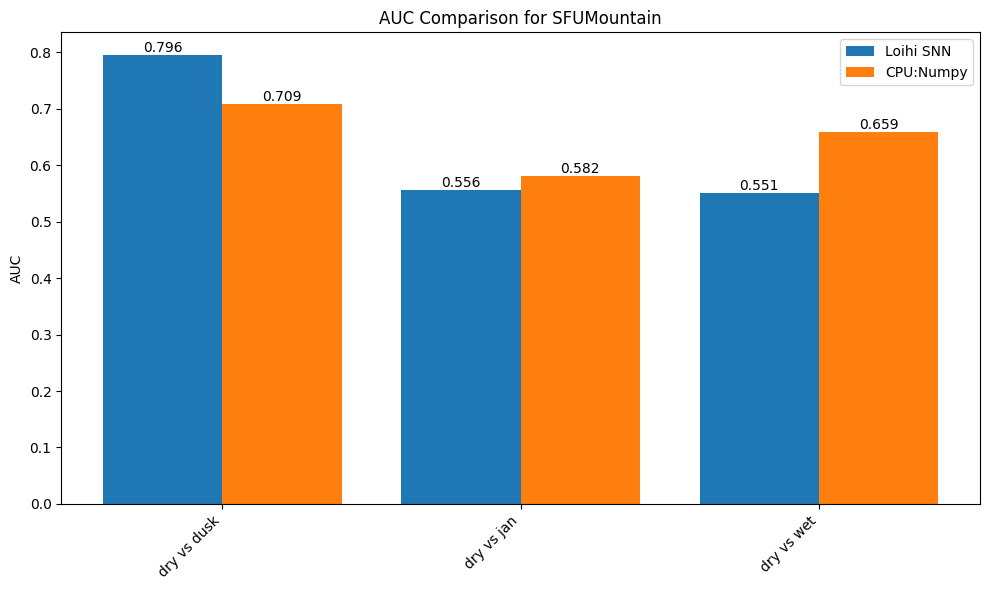

In [8]:

# Combine data into a single DataFrame
new_combined_data = []
for dataset, comparisons in loihi_data.items():
    for comparison, value in comparisons.items():
        new_combined_data.append({
            "Dataset": dataset,
            "Comparison": comparison,
            "Loihi SNN": value,
            "CPU:Numpy": cpu_numpy_data.get(dataset, {}).get(comparison, None),
        })

new_df = pd.DataFrame(new_combined_data)

# Plot bar charts for each dataset
new_datasets = new_df["Dataset"].unique()
for dataset in new_datasets:
    subset = new_df[new_df["Dataset"] == dataset]
    comparisons = subset["Comparison"]
    loihi_values = subset["Loihi SNN"]
    cpu_values = subset["CPU:Numpy"]
    
    x = range(len(comparisons))
    
    plt.figure(figsize=(10, 6))
    plt.bar(x, loihi_values, width=0.4, label="Loihi SNN", align="center")
    plt.bar([i + 0.4 for i in x], cpu_values, width=0.4, label="CPU:Numpy", align="center")
    
    # Add value labels on top of each bar
    for i, v in enumerate(loihi_values):
        plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')
    for i, v in enumerate(cpu_values):
        plt.text(i + 0.4, v, f'{v:.3f}', ha='center', va='bottom')
    
    plt.xticks([i + 0.2 for i in x], comparisons, rotation=45, ha="right")
    plt.ylabel("AUC")
    plt.title(f"AUC Comparison for {dataset}")
    plt.legend()
    # plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

In [9]:
means_data = {
    "GardensPointWalking": {
        "Loihi SNN": np.mean([0.4264954039922729, 0.7755908048631537, 0.8036863523309037]),
        "CPU:Numpy": np.mean([0.4660135714632877, 0.7594964895309881, 0.8245687650989478])
    },
    "CMU": {
        "Loihi SNN": np.mean([0.7535629080075785, 0.7310901213993263, 0.6343342394233842, 0.5140964549730641]),
        "CPU:Numpy": np.mean([0.7114807137837953, 0.7097341186912527, 0.6305503198813669, 0.6825789106649272])
    },
    "SFUMountain": {
        "Loihi SNN": np.mean([0.7958713069198795, 0.5564577717582593, 0.5512968533207703]),
        "CPU:Numpy": np.mean([0.7094702633209764, 0.5816537507527371, 0.6587555217913912])
    }
}

In [10]:
import scienceplots
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('science')
mpl.rcParams['figure.dpi'] = 300

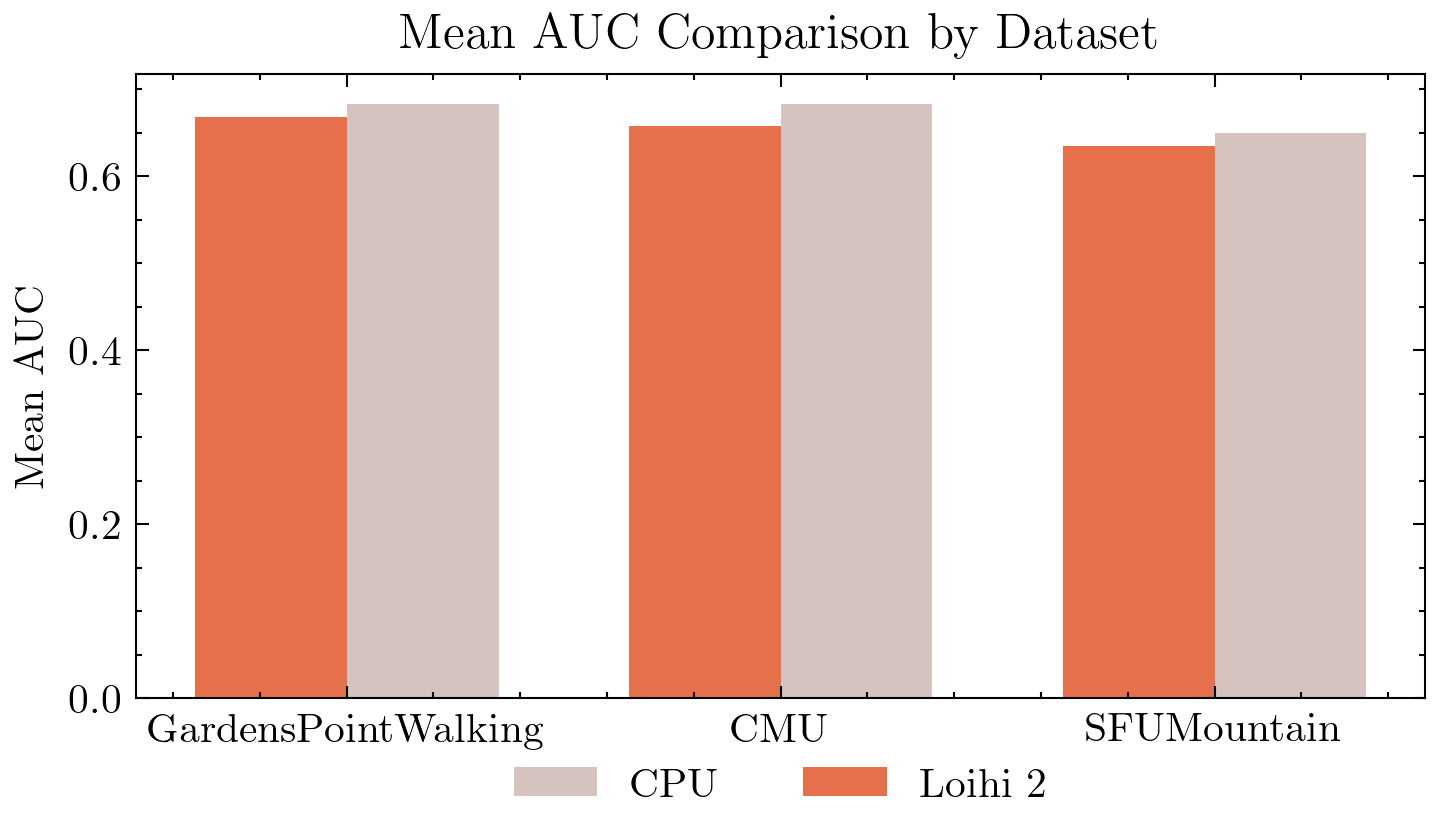

In [11]:
# Create bar plot comparing means
plt.figure(figsize=(5, 3))

# Get data in plottable format
datasets = list(means_data.keys())
loihi_means = [means_data[dataset]["Loihi SNN"] for dataset in datasets]
cpu_means = [means_data[dataset]["CPU:Numpy"] for dataset in datasets]

x = np.arange(len(datasets))
width = 0.35  # Width of bars

# Create bars

plt.bar(x + width/2, cpu_means, width, label='CPU', color='#d4c3be') 
plt.bar(x - width/2, loihi_means, width, label='Loihi 2', color='#e6704c')  # dark ash


# Customize plot
plt.ylabel('Mean AUC')
plt.title('Mean AUC Comparison by Dataset')
plt.xticks(x, datasets)
plt.legend(bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=2)
# plt.grid(axis='y')


# Add value labels on top of each bar
# for i, v in enumerate(loihi_means):
#     plt.text(i - width/2, v, f'{v:.3f}', ha='center', va='bottom')
# for i, v in enumerate(cpu_means):
#     plt.text(i + width/2, v, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()